In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from functools import reduce
from customized import preprocess
from customized import metrics
from customized import dimension_reducer
from customized.model import vae
from customized.model import autoencoder
from customized.model import temporal_context_models
import plotly.io as pio
pio.renderers.default = 'iframe'
# importlib.reload(vae)

In [3]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')

end_date = '2021-11-01'
sub_txn = txn[txn.user_id.isin(['10891','12235','6112','6835','6897','4460','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='streamer_static_features_7.csv'

rfm, static_df = preprocess.generate_static_user_context(sub_txn, end_date)
streamer = preprocess.generate_streamer_features(streamer_static_fname, sub_txn, prod, cmt, rfm, end_date) # 製作streamer features
scale_streamer = preprocess.standardize(streamer)     # 標準化

# Temporal Context Model

In [4]:
cs_model = temporal_context_models.CustomerStreamer(sub_txn, end_date, streamer, scale_streamer, static_df)
streamer_trues, streamer_preds, streamer_hn, cust_streamer_preds, cust_id, txn_n = cs_model.test(sequence_length=5, batch_size=32)
cp_model = temporal_context_models.CustomerProduct(sub_txn, end_date, static_df)
basket_trues, basket_preds, basket_hn, cust_basket_preds, cust_id2, prod_n = cp_model.test(sequence_length=10, batch_size=32)

付款單號不等於t筆: 0
(37442, 115) (37442,)
Finall Accuracy: 95.5798 %
matching of # of customers incorrects:  0
付款單號不等於t筆: 0
(19906, 7680) (19906, 768)
623
Step [100/623], Loss: 0.0082
Step [200/623], Loss: 0.0065
Step [300/623], Loss: 0.0085
Step [400/623], Loss: 0.0080
Step [500/623], Loss: 0.0087
Step [600/623], Loss: 0.0079
matching of # of customers incorrects:  0


# Full Context

### LERS

In [151]:
streamer_hn_df = pd.DataFrame(streamer_hn, index=cust_id, columns=['sdim_'+str(i+1) for i in range(streamer_hn.shape[1])]).reset_index().rename(columns={"index":"asid"})
product_hn_df = pd.DataFrame(basket_hn, index=cust_id2, columns=['pdim_'+str(i+1) for i in range(basket_hn.shape[1])]).reset_index().rename(columns={"index":"asid"})
# static
scale_rfml_df = preprocess.standardize(static_df.iloc[:,:5].set_index('asid').astype(np.float32))
static_dummy_tanh_df = static_df.set_index('asid').iloc[:,6:19].mask(static_df.set_index('asid').iloc[:,4:] == 0, -1)
static_address = static_df.set_index('asid').iloc[:,6:].to_numpy()
static_address.shape

(143327, 55)

In [152]:
static_address = dimension_reducer.pca_df(static_address, static_df.asid, 20)
static_address.shape

Explainess: [0.22909832 0.13536825 0.08377493 0.06437106 0.05017227 0.04758378
 0.04448649 0.04259471 0.03994486 0.03092169 0.02926478 0.02526031
 0.02324455 0.01993683 0.017611   0.01375348 0.01333599 0.01215072
 0.01150722 0.00959112]
Total explain: 0.9439723492615314


(143327, 20)

In [165]:
np.save('data/basket_context.npy', basket_hn)
dfs = [product_hn_df, streamer_hn_df] # temporal
streamer_cut = reduce(lambda left,right: pd.merge(left, right, how='left', on='asid'), dfs)
streamer_cut = streamer_cut[streamer_cut.asid.isin(cust_id2)].iloc[:, 257:].to_numpy()
# np.save('data/streamer_context.npy', streamer_cut)

In [164]:
# dfs = [product_hn_df, streamer_hn_df, scale_rfml_df] # rfm
# dfs = [product_hn_df, streamer_hn_df, scale_rfml_df, static_dummy_tanh_df] # rfm + purchase method
# dfs = [product_hn_df, streamer_hn_df, scale_rfml_df, static_address] # rfm + purchase method + address
dfs = [scale_rfml_df, static_address] # static
# dfs = [product_hn_df, streamer_hn_df] # temporal
context = preprocess.combine_context(dfs, cust_id2)
# np.save('data/static_context.npy', context)

(19906, 408)


#### VAE模糊化之前, 先用pca看看效果、選擇要降多少維度

In [66]:
# streamer不降(因為已經夠低了)但是要做模糊化
dimension_reducer.pca_df(static_address, static_df.asid, 30) 
dimension_reducer.pca_df(basket_hn, cust_id2, 32)

Explainess: [0.22909832 0.13536825 0.08377493 0.06437106 0.05017227 0.04758378
 0.04448649 0.04259471 0.03994486 0.03092169 0.02926478 0.02526031
 0.02324455 0.01993683 0.017611   0.01375348 0.01333599 0.01215072
 0.01150722 0.00959112 0.0082919  0.00815422 0.00745158 0.00729814
 0.00644896 0.00517256 0.00473706 0.00267092 0.00195927 0.00118188]
Total explain: 0.9973388410250906
Explainess: [6.10746145e-01 1.92110553e-01 5.50991185e-02 4.77113388e-02
 2.80929562e-02 2.32154112e-02 1.28170550e-02 9.90252476e-03
 4.27833386e-03 2.71555618e-03 2.15033232e-03 1.67564116e-03
 1.32861070e-03 1.29393220e-03 7.27524632e-04 6.84321392e-04
 6.52528834e-04 5.68608462e-04 4.56857582e-04 3.64573178e-04
 3.35672259e-04 3.04722518e-04 2.36520660e-04 2.16500383e-04
 1.99679445e-04 1.71418040e-04 1.54372814e-04 1.23389153e-04
 1.17565265e-04 9.93382346e-05 9.82385754e-05 7.94150546e-05]
Total explain: 0.9987287560434197


,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10,...,Dim23,Dim24,Dim25,Dim26,Dim27,Dim28,Dim29,Dim30,Dim31,Dim32
125129722259153,0.953689,0.408124,-0.129276,-0.002182,0.234946,-0.118067,-0.088108,0.035394,-0.044813,0.074998,...,-0.010148,0.014358,-0.009130,-0.036990,-0.006538,0.000930,-0.007034,-0.001732,-0.001497,-9.622962e-07
2575412702478335,0.911385,0.518665,0.011071,-0.026432,-0.246294,0.167438,0.060353,-0.014252,0.030706,-0.020583,...,-0.000900,0.001881,0.004004,-0.002322,0.000977,-0.000962,0.009579,-0.001813,-0.005223,4.857252e-03
2746992212059034,0.465553,-0.755920,-0.022828,0.045307,0.011415,0.029966,0.046019,-0.034181,0.041227,-0.007790,...,-0.002269,0.008103,0.003253,0.000712,0.011596,0.006285,-0.005963,-0.011646,-0.000970,3.089650e-04
10212756098496013,0.961781,0.471751,-0.073009,0.027085,0.055066,-0.059223,0.036767,-0.013443,0.029883,-0.023816,...,-0.001579,-0.004646,0.000558,0.006719,0.008260,-0.000044,0.012631,-0.001896,0.002299,1.730379e-03
3099195943438669,0.094603,0.346868,-0.064475,0.157722,-0.150822,0.047255,0.354710,0.433873,-0.037112,0.004780,...,0.028340,-0.024447,0.002510,-0.002202,-0.002325,-0.016023,0.027759,-0.024989,0.002807,1.147297e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614923358694734,0.931563,0.364787,-0.118504,0.075223,0.356556,-0.296009,-0.028680,-0.001272,0.000547,-0.023921,...,0.003463,-0.009663,-0.006675,0.003265,0.000301,-0.001063,0.006775,-0.004161,-0.005025,-8.853715e-03
1568024236727656,0.860213,0.334923,-0.145528,0.092568,0.457137,-0.380041,-0.026060,-0.007536,0.029613,-0.046465,...,0.018909,-0.001186,0.001051,0.005197,-0.013090,0.003155,-0.001487,0.000587,0.000139,-5.573975e-03
3745068162189732,0.922823,0.359797,-0.127003,0.067114,0.369588,-0.291696,-0.041872,0.002188,-0.014002,-0.009047,...,0.006844,-0.009863,-0.000590,0.004866,-0.011721,-0.000596,-0.001324,-0.001493,0.002348,-1.868315e-03
2919564371392996,-0.817423,0.006096,-0.125948,-0.061267,0.032567,-0.033010,0.193207,-0.007060,0.326964,0.083698,...,0.009005,0.067910,0.017646,-0.073990,0.024326,0.080718,0.023373,0.029957,-0.050624,3.789135e-02


# VAE

### blurry basket hn

In [72]:
vae_model = vae.VAE()
loss_vae_basket = vae_model.mytrain(basket_hn, "basket_hn", z_dims=[32, 64])
_, _, blurry_basket = vae_model.mytest(basket_hn, "basket_hn", z_dim=32, batch_size=64, weight=2)

z-dim: 32 Batch size:  64
Epoch[5/30], Step [209/209], Total Loss: 0.0048, Reconst Loss: 0.0046, KL Div: 0.0002
Epoch[10/30], Step [209/209], Total Loss: 0.0046, Reconst Loss: 0.0045, KL Div: 0.0001
Epoch[15/30], Step [209/209], Total Loss: 0.0046, Reconst Loss: 0.0046, KL Div: 0.0001
Epoch[20/30], Step [209/209], Total Loss: 0.0045, Reconst Loss: 0.0045, KL Div: 0.0000
Epoch[25/30], Step [209/209], Total Loss: 0.0045, Reconst Loss: 0.0045, KL Div: 0.0000
Epoch[30/30], Step [209/209], Total Loss: 0.0045, Reconst Loss: 0.0045, KL Div: 0.0000
[Testing] Step [103/103], Total Loss: 0.0034, Reconst Loss: 0.0033, KL Div: 0.0001
z-dim: 64 Batch size:  64
Epoch[5/30], Step [209/209], Total Loss: 0.0049, Reconst Loss: 0.0045, KL Div: 0.0004
Epoch[10/30], Step [209/209], Total Loss: 0.0047, Reconst Loss: 0.0046, KL Div: 0.0001
Epoch[15/30], Step [209/209], Total Loss: 0.0046, Reconst Loss: 0.0045, KL Div: 0.0001
Epoch[20/30], Step [209/209], Total Loss: 0.0046, Reconst Loss: 0.0045, KL Div: 0.00

Training (z=32) : 0.0045
Validation (z=32) : 0.0034
Training (z=64) : 0.0046
Validation (z=64) : 0.0036


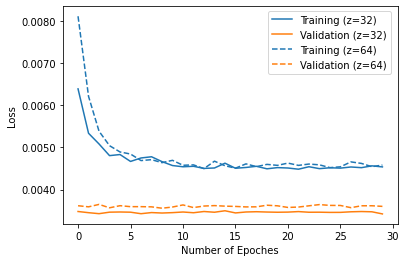

In [73]:
metrics.plot_loss_wt_val(loss_vae_basket, 'vae_basket')

### blurry streamer hn

In [85]:
loss_vae_streamer = vae_model.mytrain(streamer_hn, "streamer_hn", z_dims = [23])
_, _, blurry_streamer = vae_model.mytest(streamer_hn, "streamer_hn", z_dim=23, batch_size=64, weight=2)

z-dim: 23 Batch size:  64
Epoch[5/30], Step [392/392], Total Loss: 0.3757, Reconst Loss: 0.3682, KL Div: 0.0075
Epoch[10/30], Step [392/392], Total Loss: 0.3619, Reconst Loss: 0.3606, KL Div: 0.0013
Epoch[15/30], Step [392/392], Total Loss: 0.3603, Reconst Loss: 0.3602, KL Div: 0.0001
Epoch[20/30], Step [392/392], Total Loss: 0.3618, Reconst Loss: 0.3618, KL Div: 0.0000
Epoch[25/30], Step [392/392], Total Loss: 0.3616, Reconst Loss: 0.3616, KL Div: 0.0000
Epoch[30/30], Step [392/392], Total Loss: 0.3627, Reconst Loss: 0.3627, KL Div: -0.0000
[Testing] Step [194/194], Total Loss: 0.2843, Reconst Loss: 0.2843, KL Div: 0.0000
save results at weight: 2
testing weight: 2
Step [586/586], Total Loss: 0.5005, Reconst Loss: 0.5005, KL Div: 0.0000
testing weight: 3
Step [586/586], Total Loss: 0.4965, Reconst Loss: 0.4965, KL Div: 0.0000
testing weight: 4
Step [586/586], Total Loss: 0.5183, Reconst Loss: 0.5183, KL Div: 0.0000
testing weight: 5
Step [586/586], Total Loss: 0.5323, Reconst Loss: 0.

Training (z=23) : 0.3627
Validation (z=23) : 0.2843


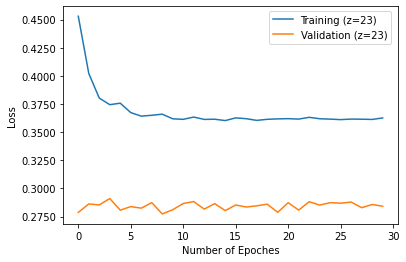

In [86]:
metrics.plot_loss_wt_val(loss_vae_streamer, 'vae_streamer')

### blurry static context

In [94]:
loss_vae_static = vae_model.mytrain(static_address.astype('float32'), "static", z_dims = [20, 30])
_, _, blurry_static = vae_model.mytest(static_address.astype('float32'), "static", z_dim=20, batch_size=64, weight=2)

z-dim: 20 Batch size:  64
Epoch[5/30], Step [1501/1501], Total Loss: 0.0391, Reconst Loss: 0.0390, KL Div: 0.0001
Epoch[10/30], Step [1501/1501], Total Loss: 0.0391, Reconst Loss: 0.0391, KL Div: 0.0000
Epoch[15/30], Step [1501/1501], Total Loss: 0.0391, Reconst Loss: 0.0391, KL Div: 0.0000
Epoch[20/30], Step [1501/1501], Total Loss: 0.0390, Reconst Loss: 0.0390, KL Div: 0.0000
Epoch[25/30], Step [1501/1501], Total Loss: 0.0390, Reconst Loss: 0.0390, KL Div: -0.0000
Epoch[30/30], Step [1501/1501], Total Loss: 0.0391, Reconst Loss: 0.0391, KL Div: -0.0000
[Testing] Step [740/740], Total Loss: 0.0352, Reconst Loss: 0.0352, KL Div: -0.0000
z-dim: 30 Batch size:  64
Epoch[5/30], Step [1501/1501], Total Loss: 0.0395, Reconst Loss: 0.0393, KL Div: 0.0002
Epoch[10/30], Step [1501/1501], Total Loss: 0.0390, Reconst Loss: 0.0390, KL Div: 0.0000
Epoch[15/30], Step [1501/1501], Total Loss: 0.0389, Reconst Loss: 0.0389, KL Div: 0.0000
Epoch[20/30], Step [1501/1501], Total Loss: 0.0388, Reconst Los

Training (z=20) : 0.0391
Validation (z=20) : 0.0352
Training (z=30) : 0.039
Validation (z=30) : 0.0356


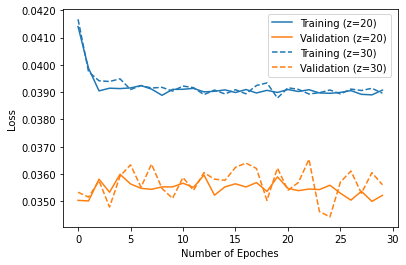

In [95]:
metrics.plot_loss_wt_val(loss_vae_static, 'vae_static')

### concatenate blurry context

In [100]:
print("total", blurry_basket.shape[1] + blurry_streamer.shape[1] + blurry_static.shape[1])
blurry_basket.shape, blurry_streamer.shape, blurry_static.shape

total 75


((19906, 32), (37442, 23), (143327, 20))

In [114]:
blurry_streamer_df = pd.DataFrame(blurry_streamer, index=cust_id, columns=['sdim_'+str(i+1) for i in range(blurry_streamer.shape[1])]).reset_index().rename(columns={"index":"asid"})
blurry_basket_df = pd.DataFrame(blurry_basket, index=cust_id2, columns=['pdim_'+str(i+1) for i in range(blurry_basket.shape[1])]).reset_index().rename(columns={"index":"asid"})
blurry_static_df = pd.DataFrame(blurry_static, index=static_df.asid, columns=['cdim_'+str(i+1) for i in range(blurry_static.shape[1])]).reset_index().rename(columns={"index":"asid"})

dfs = [blurry_basket_df, blurry_streamer_df, blurry_static_df] # three blurry features
blurry_context = preprocess.combine_context(dfs, cust_id2)
np.save('data/blurry_context_new.npy', blurry_context)

(19906, 75)


# AE

## Full context

### latent basket hn

In [105]:
ae_model = autoencoder.AutoEncoder()
ae_loss_basket = ae_model.mytrain(basket_hn, "basket_hn", z_dims = [32])
_, _, basket_latent = ae_model.mytest(basket_hn, "basket_hn", z_dim=32, batch_size=128)

z-dim: 32 Batch size:  128
Epoch[5/30], Step [105/105], Reconstructed Loss: 0.0001
Epoch[10/30], Step [105/105], Reconstructed Loss: 0.0001
Epoch[15/30], Step [105/105], Reconstructed Loss: 0.0000
Epoch[20/30], Step [105/105], Reconstructed Loss: 0.0000
Epoch[25/30], Step [105/105], Reconstructed Loss: 0.0000
Epoch[30/30], Step [105/105], Reconstructed Loss: 0.0000
[Testing] Step [52/52], Reconstructed Loss: 0.0000
Step [156/156], Reconstructed Loss: 0.0004


Training (z=32) : 0.0
Validation (z=32) : 0.0


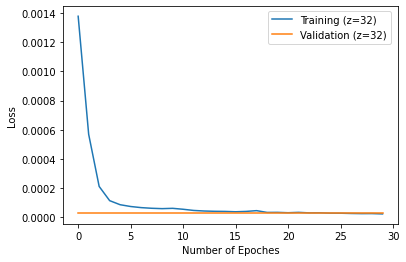

In [106]:
metrics.plot_loss_wt_val(ae_loss_basket, 'ae_basket')

### latent streamer hn

In [103]:
ae_loss_streamer = ae_model.mytrain(streamer_hn, "streamer_hn", z_dims = [23])
_, _, streamer_latent = ae_model.mytest(streamer_hn, "streamer_hn", z_dim=23, batch_size=128)

z-dim: 23 Batch size:  128
Epoch[5/30], Step [196/196], Reconstructed Loss: 0.0168
Epoch[10/30], Step [196/196], Reconstructed Loss: 0.0104
Epoch[15/30], Step [196/196], Reconstructed Loss: 0.0078
Epoch[20/30], Step [196/196], Reconstructed Loss: 0.0064
Epoch[25/30], Step [196/196], Reconstructed Loss: 0.0056
Epoch[30/30], Step [196/196], Reconstructed Loss: 0.0049
[Testing] Step [97/97], Reconstructed Loss: 0.0061
Step [293/293], Reconstructed Loss: 0.0043


Training (z=23) : 0.0049
Validation (z=23) : 0.0061


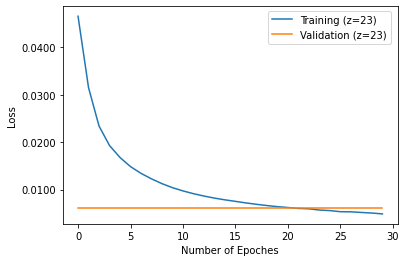

In [104]:
metrics.plot_loss_wt_val(ae_loss_streamer, 'ae_streamer')

### latent static

In [107]:
ae_loss_static = ae_model.mytrain(static_address.astype('float32'), "static", z_dims = [20, 30])
_, _, static_latent = ae_model.mytest(static_address.astype('float32'), "static", z_dim=20, batch_size=128)

z-dim: 20 Batch size:  128
Epoch[5/30], Step [751/751], Reconstructed Loss: 0.0028
Epoch[10/30], Step [751/751], Reconstructed Loss: 0.0019
Epoch[15/30], Step [751/751], Reconstructed Loss: 0.0004
Epoch[20/30], Step [751/751], Reconstructed Loss: 0.0003
Epoch[25/30], Step [751/751], Reconstructed Loss: 0.0003
Epoch[30/30], Step [751/751], Reconstructed Loss: 0.0002
[Testing] Step [370/370], Reconstructed Loss: 0.0003
z-dim: 30 Batch size:  128
Epoch[5/30], Step [751/751], Reconstructed Loss: 0.0012
Epoch[10/30], Step [751/751], Reconstructed Loss: 0.0003
Epoch[15/30], Step [751/751], Reconstructed Loss: 0.0004
Epoch[20/30], Step [751/751], Reconstructed Loss: 0.0003
Epoch[25/30], Step [751/751], Reconstructed Loss: 0.0003
Epoch[30/30], Step [751/751], Reconstructed Loss: 0.0003
[Testing] Step [370/370], Reconstructed Loss: 0.0002
Step [1120/1120], Reconstructed Loss: 0.0004


Training (z=20) : 0.0002
Validation (z=20) : 0.0003
Training (z=30) : 0.0003
Validation (z=30) : 0.0002


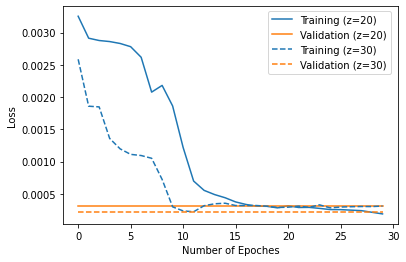

In [108]:
metrics.plot_loss_wt_val(ae_loss_static, 'ae_static')

### concatenate full context

In [156]:
print("total", basket_latent.shape[1] + streamer_latent.shape[1] + static_latent.shape[1])
basket_latent.shape, streamer_latent.shape, static_latent.shape

total 75


((19906, 32), (37442, 23), (143327, 20))

In [113]:
streamer_latent_df = pd.DataFrame(streamer_latent, index=cust_id, columns=['sdim_'+str(i+1) for i in range(streamer_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
basket_latent_df = pd.DataFrame(basket_latent, index=cust_id2, columns=['pdim_'+str(i+1) for i in range(basket_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
static_latent_df = pd.DataFrame(static_latent, index=static_df.asid, columns=['cdim_'+str(i+1) for i in range(static_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})

dfs = [basket_latent_df, streamer_latent_df, static_latent_df] 
latent_context = preprocess.combine_context(dfs, cust_id2)
np.save('data/latent_context_new.npy', latent_context)

(19906, 75)


In [140]:
streamer_latent_df = pd.DataFrame(streamer_latent, index=cust_id, columns=['sdim_'+str(i+1) for i in range(streamer_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
dfs = [basket_latent_df, streamer_latent_df] 
streamer_cut = reduce(lambda left,right: pd.merge(left, right, how='left', on='asid'), dfs)
streamer_cut = streamer_cut[streamer_cut.asid.isin(cust_id2)].iloc[:, 33:].to_numpy()
np.save('data/basket_latent.npy', basket_latent)
np.save('data/streamer_latent.npy', streamer_cut)

## Temporal context

In [112]:
streamer_latent_df = pd.DataFrame(streamer_latent, index=cust_id, columns=['sdim_'+str(i+1) for i in range(streamer_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
basket_latent_df = pd.DataFrame(basket_latent, index=cust_id2, columns=['pdim_'+str(i+1) for i in range(basket_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})

dfs = [basket_latent_df, streamer_latent_df] 
temporal_context = preprocess.combine_context(dfs, cust_id2)
np.save('data/temporal_context_new.npy', temporal_context)

(19906, 55)


## Static context

In [117]:
static_latent_df = pd.DataFrame(static_latent, index=static_df.asid, columns=['cdim_'+str(i+1) for i in range(static_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
static_latent_df = static_latent_df[static_latent_df.asid.isin(cust_id2)]
static_latent_df = static_latent_df.set_index('asid')
static_context = static_latent_df.loc[cust_id2].to_numpy()
print(static_context.shape)
np.save('data/static_context_new.npy', static_context)

(19906, 20)


## MAB context (static + Bt + St)

In [118]:
basket_seq_prods_mab, _ = preprocess.generate_basket_list(prod_n, 10)
mabBt = preprocess.cal_basket_embedding(basket_seq_prods_mab[basket_seq_prods_mab.seq==10])
mabSt = preprocess.generate_streamer_seq(txn_n[txn_n.seq==5], scale_streamer, 5)

In [119]:
ae_loss_mabBt = ae_model.mytrain(mabBt, "mabBt", z_dims = [32])
_, _, mabBt_latent = ae_model.mytest(mabBt, "mabBt", z_dim=32, batch_size=128)

[Train] change Double to Float
z-dim: 32 Batch size:  128
Epoch[5/30], Step [105/105], Reconstructed Loss: 0.0042
Epoch[10/30], Step [105/105], Reconstructed Loss: 0.0031
Epoch[15/30], Step [105/105], Reconstructed Loss: 0.0028
Epoch[20/30], Step [105/105], Reconstructed Loss: 0.0025
Epoch[25/30], Step [105/105], Reconstructed Loss: 0.0023
Epoch[30/30], Step [105/105], Reconstructed Loss: 0.0022
[Testing] Step [52/52], Reconstructed Loss: 0.0031
[Test] change Double to Float
Step [156/156], Reconstructed Loss: 0.0032


Training (z=32) : 0.0022
Validation (z=32) : 0.0031


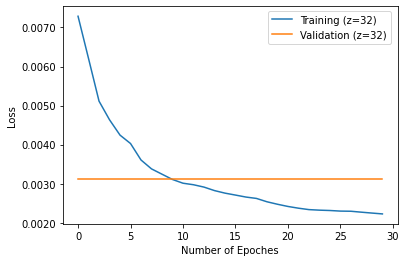

In [120]:
metrics.plot_loss_wt_val(ae_loss_mabBt, 'ae_mabBt')

In [121]:
ae_loss_mabSt = ae_model.mytrain(mabSt, "mabSt", z_dims = [23])
_, _, mabSt_latent = ae_model.mytest(mabSt, "mabSt", z_dim=23, batch_size=128)

[Train] change Double to Float
z-dim: 23 Batch size:  128
Epoch[5/30], Step [196/196], Reconstructed Loss: 0.1709
Epoch[10/30], Step [196/196], Reconstructed Loss: 0.1706
Epoch[15/30], Step [196/196], Reconstructed Loss: 0.1704
Epoch[20/30], Step [196/196], Reconstructed Loss: 0.1704
Epoch[25/30], Step [196/196], Reconstructed Loss: 0.1702
Epoch[30/30], Step [196/196], Reconstructed Loss: 0.1700
[Testing] Step [97/97], Reconstructed Loss: 0.1806
[Test] change Double to Float
Step [293/293], Reconstructed Loss: 0.1386


Training (z=23) : 0.17
Validation (z=23) : 0.1806


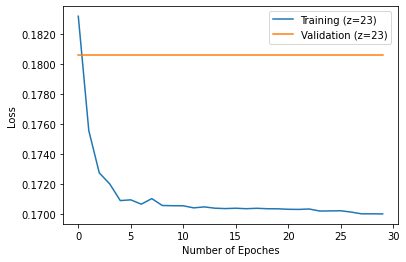

In [122]:
metrics.plot_loss_wt_val(ae_loss_mabSt, 'ae_mabSt')

### concatenate MAB context

In [123]:
mabBt_df = pd.DataFrame(mabBt_latent, index=cust_id2, columns=['pdim_'+str(i+1) for i in range(mabBt_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
mabSt_df = pd.DataFrame(mabSt_latent, index=cust_id, columns=['sdim_'+str(i+1) for i in range(mabSt_latent.shape[1])]).reset_index().rename(columns={"index":"asid"})
dfs = [mabBt_df, mabSt_df, static_latent_df]
full_context_mab = preprocess.combine_context(dfs, cust_id2)
np.save('data/mab_context_new.npy', full_context_mab)

(19906, 75)


#### 預測目標: 各店家在下一場(隔天)直播的商品數

In [7]:
next_date = '2021-11-02'
sequence_length=10 # 取小的
prod_t, trim_cust_list = preprocess.trim_cust_prod_n(sequence_length, sub_txn, end_date)
rec_prod_df = {}
data = {}
reward_df = {}
cust_has_ans_list = []
user = list(sorted(set(sub_txn.user_id)))

for u in user:
    rec_prod_df[u], rec_prod_list_all = preprocess.get_rec_prod_list(u, sub_txn, next_date)
    for channel in [rec_prod_df[u]]:
        nameList, data['super_like_'+str(u)], data['super_like_prod_id_'+str(u)], data['super_like_cust_id_'+str(u)], \
        data['like_'+str(u)], data['like_prod_id_'+str(u)], data['like_cust_id_'+str(u)], \
        data['potential_like_'+str(u)], data['potential_like_prod_id_'+str(u)], data['potential_like_cust_id_'+str(u)] = \
        preprocess.channel_answer(u, channel, sub_txn, prod_t, sequence_length, next_date, trim_cust_list)
    reward_df[str(u)] = preprocess.generate_reward_df(data['super_like_'+str(u)], data['potential_like_'+str(u)])
    cust_has_ans_list += data['super_like_cust_id_'+str(u)]
    cust_has_ans_list += data['potential_like_cust_id_'+str(u)]
    print(round(reward_df[u].reward.value_counts() / reward_df[u].shape[0], 4))
    test = pd.pivot_table(data=reward_df[u], index='asid', columns='商品id', values="reward", fill_value=0)
    if not test.empty:
        print(f"0佔比: {(test == 0).sum().sum() / (test.shape[0]*test.shape[1]):.4f}, \
                1佔比: {(test == 1).sum().sum() / (test.shape[0]*test.shape[1]):.4f}, \
                0.5佔比: {(test == 0.5).sum().sum() / (test.shape[0]*test.shape[1]):.4f} ")
    print("===============================")
cust_has_ans_list = list(set(cust_has_ans_list))
print(f'全部共: {len(cust_has_ans_list)} 人有答案 ({(len(cust_has_ans_list)/len(trim_cust_list) * 100):.2f}%)')

訂單大於t+1筆的人數(切齊至t+1筆為同一天end_date): 2630
頻道 10891 在下一場直播中共有 597 個商品
[一年內有買] 商品數: 436, 人數: 459
[在t+1時有買] 商品數: 284, 人數: 405
[非t+1但半年內有買] 商品數: 136, 人數: 147
有 2193 個人沒有答案; 437 人有答案
=====
1.0    0.7191
0.5    0.2809
Name: reward, dtype: float64
0佔比: 0.9898,                 1佔比: 0.0073,                 0.5佔比: 0.0029 
頻道 12235 在下一場直播中共有 76 個商品
[一年內有買] 商品數: 56, 人數: 53
[在t+1時有買] 商品數: 25, 人數: 41
[非t+1但半年內有買] 商品數: 19, 人數: 21
有 2581 個人沒有答案; 49 人有答案
=====
1.0    0.686
0.5    0.314
Name: reward, dtype: float64
0佔比: 0.9538,                 1佔比: 0.0317,                 0.5佔比: 0.0145 
頻道 4460 在下一場直播中共有 110 個商品
[一年內有買] 商品數: 6, 人數: 7
[在t+1時有買] 商品數: 4, 人數: 5
[非t+1但半年內有買] 商品數: 1, 人數: 1
有 2624 個人沒有答案; 6 人有答案
=====
1.0    0.8571
0.5    0.1429
Name: reward, dtype: float64
0佔比: 0.7667,                 1佔比: 0.2000,                 0.5佔比: 0.0333 
頻道 4793 在下一場直播中共有 72 個商品
[一年內有買] 商品數: 58, 人數: 159
[在t+1時有買] 商品數: 40, 人數: 150
[非t+1但半年內有買] 商品數: 14, 人數: 29
有 2479 個人沒有答案; 151 人有答案
=====
1.0    0.9255
0.5    0.0745
Name: 

# Plot AE z space

In [130]:
fit = latent_vector 
# np.save("data/orig_latent.npy", orig_latent) # 沒有加address的

## PCA

Explainess: [0.3325444  0.28178966]
Total explain: 0.6143340468406677


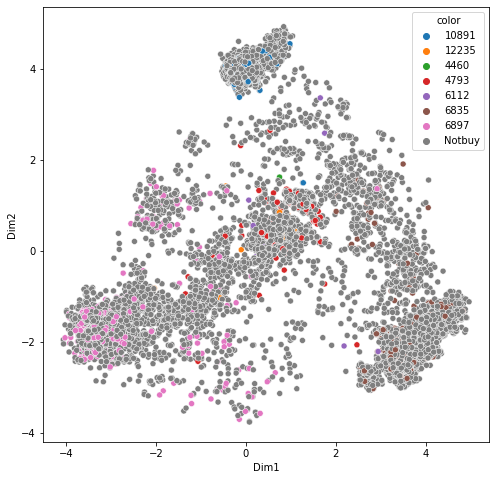

In [110]:
pca_2d = dimension_reducer.pca_df(fit, cust_id2, 2)
pca_2d_df = metrics.df_for_plot(pca_2d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_2d_scatter(pca_2d_df, "pca_notbuy", hue='color', hue_order=user+['Notbuy'])

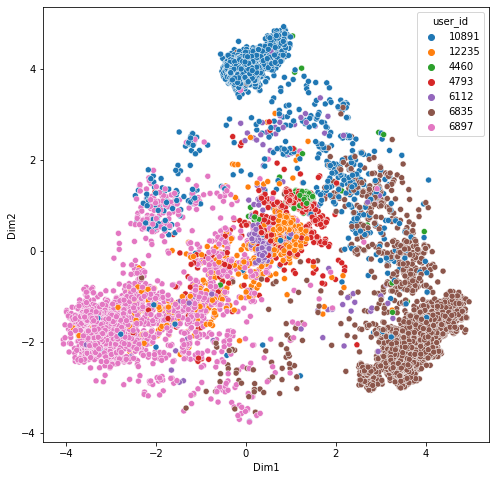

In [111]:
metrics.plot_2d_scatter(pca_2d_df, "pca", hue='user_id', hue_order=user)

In [112]:
pca_3d = dimension_reducer.pca_df(fit, cust_id2, 3)
pca_3d_df = metrics.df_for_plot(pca_3d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_3d_discrete(pca_3d_df)

Explainess: [0.3325445  0.28178933 0.11878078]
Total explain: 0.7331146225333214


## TSNE=2

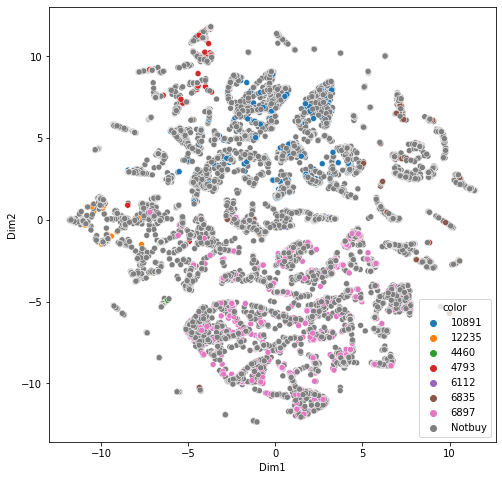

In [113]:
tsne_2d = dimension_reducer.tsne_df(fit, cust_id2, dim=2)
tsne_2d_df = metrics.df_for_plot(tsne_2d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_2d_scatter(tsne_2d_df, 'tsne', 'user_id', user+['Notbuy'])

## TSNE=3

In [114]:
tsne_3d = dimension_reducer.tsne_df(fit, cust_id2, dim=3)
tsne_3d_df = metrics.df_for_plot(tsne_3d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_3d_discrete(tsne_3d_df)

### Basket colors

In [115]:
basket_emb = preprocess.cal_basket_embedding(tsne_3d_df)
ae_basket_model = autoencoder.AutoEncoder()
# loss_ae = ae_basket_model.mytrain(basket_emb, "basket_emb")
ae_basket_trues, ae_basket_preds, latent_basket_vector = ae_basket_model.mytest(basket_emb, "basket_emb", z_dim=30, batch_size=128)

basket_rgb = dimension_reducer.tsne_df(latent_basket_vector, cust_id2, dim=3).reset_index().rename(columns={'index':'asid','Dim1':'r','Dim2':'g','Dim3':'b'})
tsne_df = tsne_3d_df.merge(basket_rgb, 'left', 'asid')
tsne_df['avg_raw_rgb'] = (tsne_df.r + tsne_df.g + tsne_df.b)/3
tsne_df_wt_hex = metrics.generateHex(tsne_df)
tsne_df_wt_hex['avg_rgb'] = (tsne_df_wt_hex.r + tsne_df_wt_hex.g + tsne_df_wt_hex.b)/3

[Test] change Double to Float
Step [156/156], Reconstructed Loss: 0.0028


In [116]:
metrics.plot_3d_continuous(tsne_df, 'avg_raw_rgb')

In [117]:
metrics.plot_3d_continuous(tsne_df_wt_hex, 'avg_rgb')

## UMAP

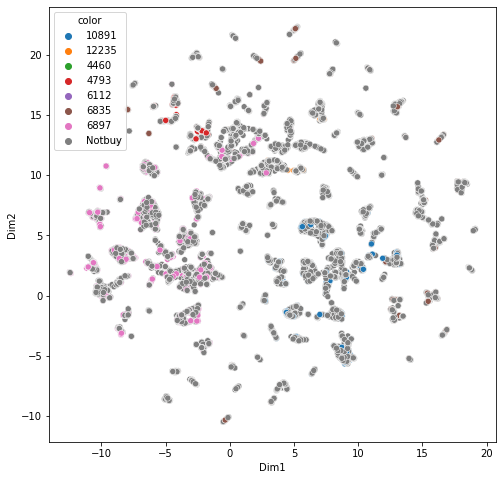

In [118]:
umap_2d = dimension_reducer.umap_df(fit, cust_id2, dim=2)
umap_2d_df = metrics.df_for_plot(umap_2d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_2d_scatter(umap_2d_df, "umap", 'user_id', user+["Notbuy"])

In [119]:
umap_3d = dimension_reducer.umap_df(fit, cust_id2, dim=3)
umap_3d_df = metrics.df_for_plot(umap_3d, txn_n, prod_n, trim_cust_list, cust_has_ans_list)
metrics.plot_3d_discrete(umap_3d_df)

In [120]:
umap_df = umap_3d_df.merge(basket_rgb, 'left', 'asid')
umap_df['avg_raw_rgb'] = (umap_df.r + umap_df.g + umap_df.b)/3
umap_df_wt_hex = metrics.generateHex(umap_df)
umap_df_wt_hex['avg_rgb'] = (umap_df_wt_hex.r + umap_df_wt_hex.g + umap_df_wt_hex.b)/3
metrics.plot_3d_continuous(umap_df_wt_hex, 'avg_rgb')